In [29]:
import sys
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Ellipse
import proplot as plot
from tqdm import tqdm

sys.path.append('/Users/46h/Research/code/accphys')
from tools import envelope_analysis as ea
from tools import plotting as myplt
from tools import utils
from tools.utils import show

In [2]:
plot.rc['figure.facecolor'] = 'white'
plot.rc['cycle'] = 'default'

# Diagonal wire-scanner

In [3]:
def rotate_bunch(X, angle):
    return utils.apply(utils.rotation_matrix_4D(angle), X)

def rms_ellipse_dims(xx, yy, xy):
    angle = -0.5 * np.arctan2(2*xy, xx-yy)
    sin, cos = np.sin(angle), np.cos(angle)
    sin2, cos2 = sin**2, cos**2
    cx = np.sqrt(abs(xx*cos2 + yy*sin2 - 2*xy*sin*cos))
    cy = np.sqrt(abs(xx*sin2 + yy*cos2 + 2*xy*sin*cos))
    return angle, cx, cy

def plot_rms_ellipse(ax, xx, yy, xy, **plt_kws):
    plt_kws.setdefault('zorder', 20)
    plt_kws.setdefault('fill', False)
    angle, cx, cy = rms_ellipse_dims(xx, yy, xy)
    ellipse = Ellipse((0, 0), 4*cx, 4*cy, -np.degrees(angle), **plt_kws)
    ax.add_patch(ellipse)
    return ax

In [111]:
def get_histograms(X, diag_ws_angle, nbins=50, noise=0.0):
    counts_x, bin_edges_x = np.histogram(X[:, 0], nbins)
    counts_y, bin_edges_y = np.histogram(X[:, 2], nbins)
    X_rot = rotate_bunch(X, diag_ws_angle)
    counts_u, bin_edges_u = np.histogram(X_rot[:, 0], nbins)
    return (counts_x, counts_y, counts_u), (bin_edges_x, bin_edges_y, bin_edges_u)

def get_bin_centers(bin_edges):
    delta = bin_edges[1] - bin_edges[0]
    return (bin_edges + 0.5 * delta)[:-1]

def get_variance(counts, bin_edges):
    positions = get_bin_centers(bin_edges)
    N = np.sum(counts)
    x_avg = np.sum(counts * positions) / (N - 1)
    x2_avg = np.sum(counts * positions**2) / (N - 1)
    return x2_avg - x_avg**2

def get_sig_xy(sig_xx, sig_yy, sig_uu, diag_ws_angle):
    assert diag_ws_angle != 0.0
    sin, cos = np.sin(diag_ws_angle), np.cos(diag_ws_angle)
    sin2, cos2 = sin**2, cos**2
    sig_xy = (sig_uu - sig_xx*cos2 - sig_yy*sin2) / (2 * sin * cos)
    return sig_xy

def get_covariances(counts, bin_edges, diag_ws_angle):
    sig_xx = get_variance(counts[0], bin_edges[0])
    sig_yy = get_variance(counts[1], bin_edges[1])
    sig_uu = get_variance(counts[2], bin_edges[2])
    sig_xy = get_sig_xy(sig_xx, sig_yy, sig_uu, diag_ws_angle)
    return sig_xx, sig_yy, sig_xy

In [112]:
nparts = 1e5
diag_ws_angle = np.radians(15.0) # [deg]
bunch_tilt_angle = np.radians(45.0)
nbins = 50

X = np.random.normal(scale=1, size=(int(nparts), 4))
X[:, 0] *= 2.0
X = rotate_bunch(X, bunch_tilt_angle)
Sigma = np.cov(X.T)

counts, bin_edges = get_histograms(X, diag_ws_angle, nbins)
sig_xx, sig_yy, sig_xy = get_covariances(counts, bin_edges, diag_ws_angle)

print('<xx>, <yy>, <xy>')
print('True: {:.3f}, {:.3f}, {:.3f}'.format(Sigma[0, 0], Sigma[2, 2], Sigma[0, 2]))
print('Calc: {:.3f}, {:.3f}, {:.3f}'.format(sig_xx, sig_yy, sig_xy))

<xx>, <yy>, <xy>
True: 2.509, 2.493, -1.496
Calc: 2.515, 2.499, -1.501


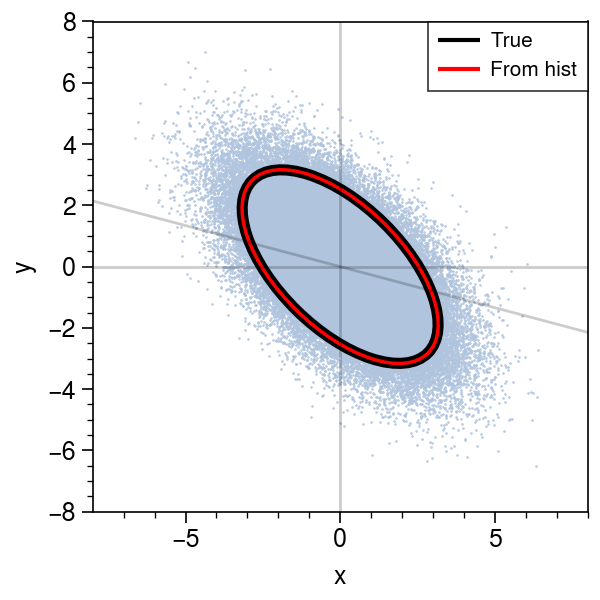

In [113]:
fig, ax = plot.subplots(figsize=(3, 3))
ax.scatter(X[:, 0], X[:, 2], s=0.1, zorder=5, c='lightsteelblue')
ax.format(xlim=(-8, 8), ylim=(-8, 8), grid=False, xlabel='x', ylabel='y')
plot_rms_ellipse(ax, Sigma[0, 0], Sigma[2, 2], Sigma[0, 2], lw=4)
plot_rms_ellipse(ax, sig_xx, sig_yy, sig_xy, color='r', lw=1.25)
ax.axhline(0, c='k', alpha=0.2, lw=1, zorder=90)
ax.axvline(0, c='k', alpha=0.2, lw=1, zorder=90);

xmin, xmax = ax.get_xlim()
ymin = -np.tan(diag_ws_angle) * xmin
ymax = -np.tan(diag_ws_angle) * xmax
ax.plot([xmin, xmax], [ymin, ymax], c='k', alpha=0.2, lw=1, zorder=90)

custom_lines = [Line2D([0], [0], color='k'), Line2D([0], [0], color='r')]
ax.legend(custom_lines, ['True', 'From hist'], ncols=1, fontsize='small');

In [115]:
ws_angles = np.linspace(0, np.pi/2, 20)
ws_angles = ws_angles[1:]
ws_angles = ws_angles[:-1]
moments_arr = []
for ws_angle in tqdm(ws_angles):
    counts, bin_edges = get_histograms(X, ws_angle, nbins=50)
    moments = get_covariances(counts, bin_edges, ws_angle)
    moments_arr.append(moments)
moments_arr = np.array(moments_arr)

100%|██████████| 18/18 [00:07<00:00,  2.54it/s]


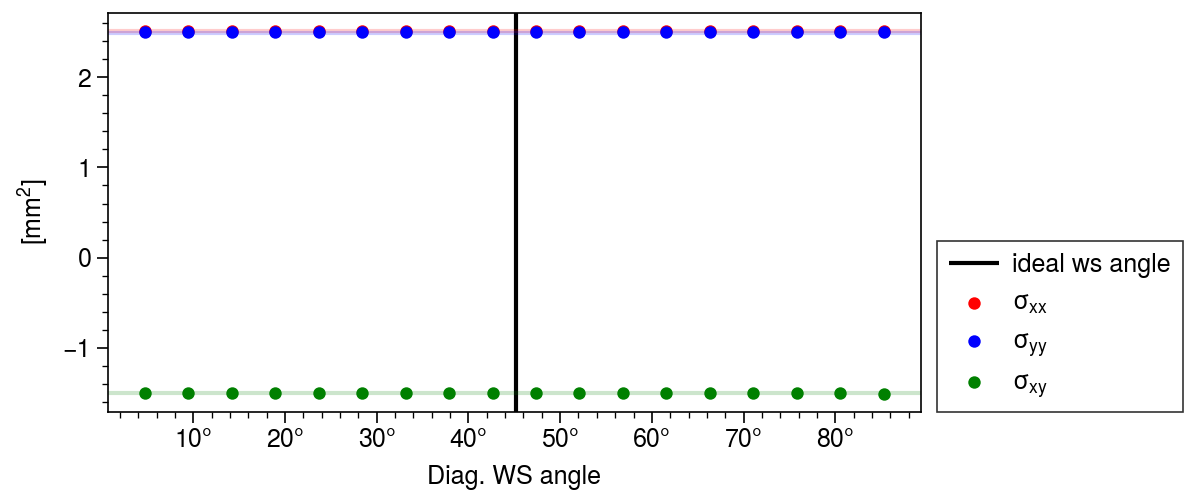

In [116]:
fig, ax = plot.subplots(figsize=(6, 2.5))
ax.format(ylabel='[mm$^2$]', xlabel='Diag. WS angle', grid=False, xformatter='deg')
for i, color in enumerate(['r', 'b', 'g']):
    ax.scatter(np.degrees(ws_angles), moments_arr[:, i], c=color, s=15)
ideal_ws_angle = np.arctan(Sigma[0, 0] / Sigma[2, 2])
ax.axvline(np.degrees(ideal_ws_angle), c='k', zorder=0);
ax.legend(labels=['ideal ws angle', r'$\sigma_{xx}$', r'$\sigma_{yy}$', r'$\sigma_{xy}$'], ncols=1, loc=(1.02, 0));
ax.axhline(Sigma[0, 0], c='red', zorder=0, alpha=0.2)
ax.axhline(Sigma[2, 2], c='blue', zorder=0, alpha=0.2)
ax.axhline(Sigma[0, 2], c='green', zorder=0, alpha=0.2);